In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ab-testing/ab_data.csv


# Load the Data

In [2]:
data = pd.read_csv("/kaggle/input/ab-testing/ab_data.csv")

In [3]:
print(data.head())

   user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1


In [4]:
missing_values = data.isnull().sum()
print(missing_values)

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


In [5]:
data_types = data.dtypes
print(data_types)

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object


# Data Cleaning

In [6]:
# users who appear in both the control and treatment groups
duplicate_users = data[data.duplicated(subset=["user_id"], keep=False)]["user_id"]
print(duplicate_users)

22        767017
192       656468
226       773693
240       733976
246       704650
           ...  
294308    905197
294309    787083
294328    641570
294331    689637
294355    744456
Name: user_id, Length: 7788, dtype: int64


In [7]:
data = data[~data["user_id"].isin(duplicate_users)]

# Descriptive Statistics

In [8]:
conversion_rates = data.groupby("group")["converted"].mean()
print(conversion_rates)

group
control      0.120173
treatment    0.118726
Name: converted, dtype: float64


In [9]:
page_views = data["landing_page"].value_counts()
print(page_views)

landing_page
new_page    143397
old_page    143293
Name: count, dtype: int64


In [10]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
session_times = data['timestamp'].agg(['min', 'median', 'max'])
print(session_times)

min      2017-01-02 13:42:05.378582000
median   2017-01-13 13:23:05.960603648
max      2017-01-24 13:41:54.460509000
Name: timestamp, dtype: datetime64[ns]


In [11]:
average_conversion_rate = data.groupby('landing_page')['converted'].mean()
print(average_conversion_rate)

landing_page
new_page    0.118726
old_page    0.120173
Name: converted, dtype: float64


# Hypothesis Formulation

## Define Hypotheses
Null Hypothesis (H₀): There is no significant difference in conversion rates between the Control and Treatment groups. (μ₁ = μ₂)
Alternative Hypothesis (H₁): There is a significant difference in conversion rates between the two groups. (μ₁ ≠ μ₂)

## Data Visualization

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

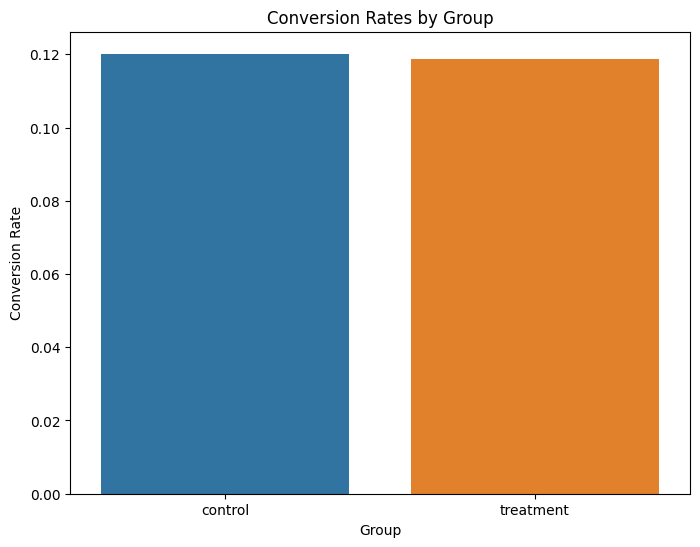

In [13]:
plt.figure(figsize=(8, 6))
sns.barplot(x=conversion_rates.index, y=conversion_rates.values)
plt.xlabel('Group')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates by Group')
plt.show()

# A/B Testing (Two-Proportion Z-Test)

In [14]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

In [15]:
control_conversions = data[data['group'] == 'control']['converted'].sum()
control_total = len(data[data['group'] == 'control'])
test_conversions = data[data['group'] == 'treatment']['converted'].sum()
test_total = len(data[data['group'] == 'treatment'])

In [16]:
count = np.array([control_conversions, test_conversions])
nobs = np.array([control_total, test_total])
z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

In [17]:
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

Z-statistic: 1.1944850812796501
P-value: 0.23228827305833621


Since p-value > 0.05, failed to reject the null hypothesis: There is no significant difference in conversion rates between the Control and Test groups. The company should not switch landing pages because of the development, testing, and deployment costs involved in switching to a new landing page.

# Confidence Intervals and Visualization

In [18]:
from statsmodels.stats.proportion import proportion_confint

In [19]:
# Calculate the 95% confidence interval for the conversion rates of both the Control and Treatment groups
control_ci = proportion_confint(control_conversions, control_total, alpha=0.05)
test_ci = proportion_confint(test_conversions, test_total, alpha=0.05)

In [20]:
groups = ['Control', 'Treatment']
conversion_rates = np.array([control_conversions / control_total, test_conversions / test_total])
error = np.array([(control_ci[1]-control_ci[0])/2, (test_ci[1]-test_ci[0])/2])

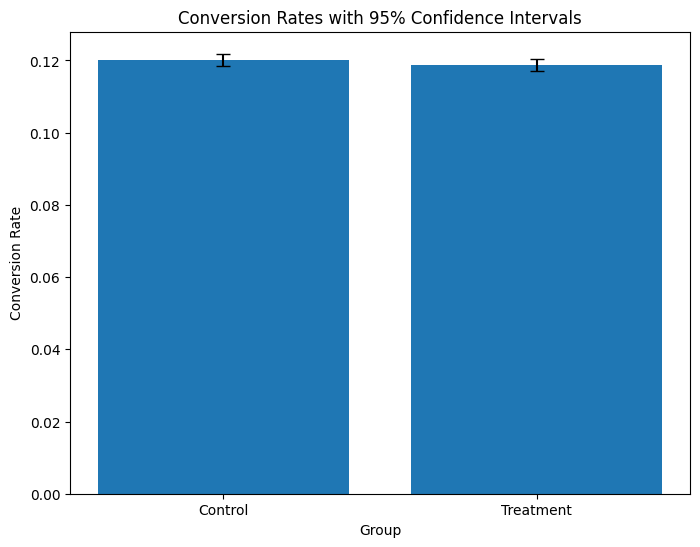

In [21]:
plt.figure(figsize=(8, 6))
plt.bar(groups, conversion_rates, yerr=error, capsize=5)
plt.xlabel('Group')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates with 95% Confidence Intervals')
plt.show()

# Subgroup Analysis

## Time-Based Analysis

In [22]:
data['hour'] = data['timestamp'].dt.hour

In [23]:
hourly_conversion_rates = data.groupby('hour')['converted'].mean()

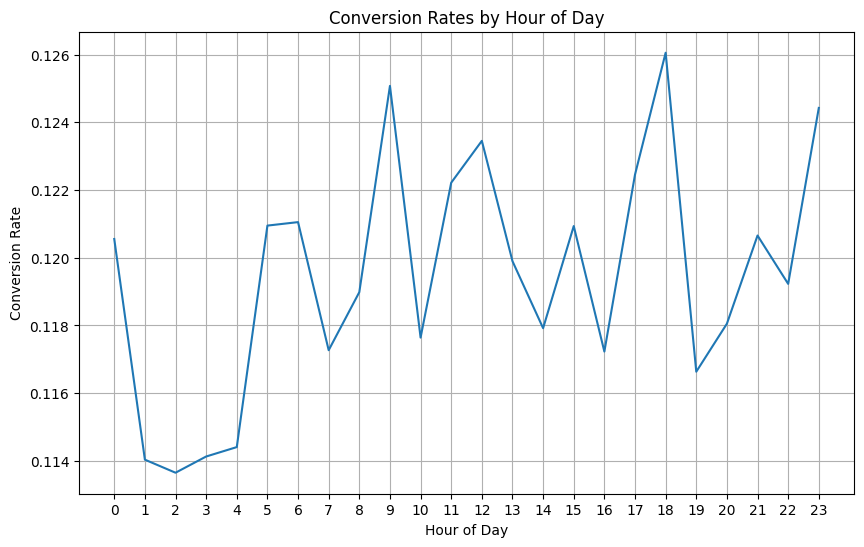

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(hourly_conversion_rates.index, hourly_conversion_rates.values)
plt.xlabel('Hour of Day')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates by Hour of Day')
plt.xticks(range(24))
plt.grid(True)
plt.show()

Conversion rates tend to be low between 1 pm and 4 pm, when people are sleeping, and high at 9 am and 6 pm, during commuting hours, 12 pm during lunch break, and 11 pm before bed.

In [25]:
hourly_conversion_by_page = data.groupby(['hour', 'landing_page'])['converted'].mean().unstack()

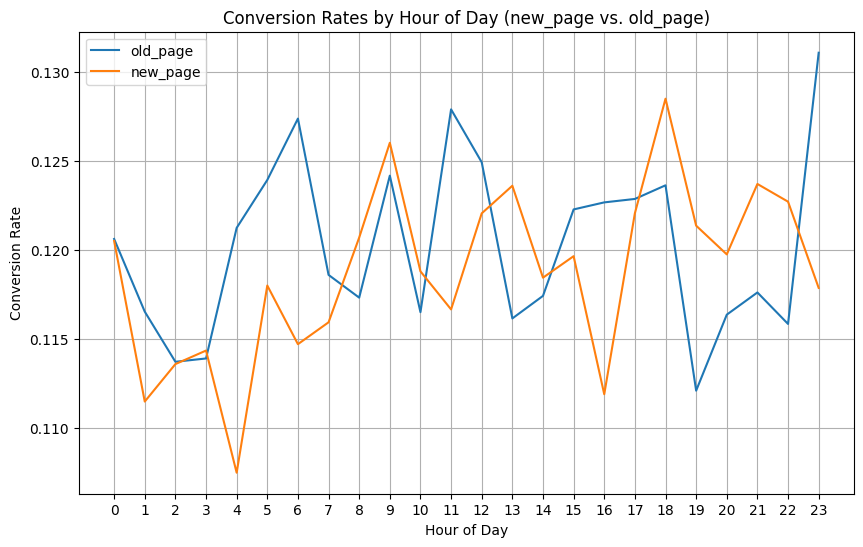

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(hourly_conversion_by_page.index, hourly_conversion_by_page['old_page'], label='old_page')
plt.plot(hourly_conversion_by_page.index, hourly_conversion_by_page['new_page'], label='new_page')
plt.xlabel('Hour of Day')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates by Hour of Day (new_page vs. old_page)')
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()

New page conversion rates tend to be lower between 4 am and 7 am, while new page conversion rates tend to be higher between 6 pm and 10 pm.

# Conclusion
AB testing was performed on the conversion rates of the old landing page and the new landing page, and no significant differences in conversion rates were found.

However, when the conversion rates were compared by time of day, there was a tendency for the conversion rate to differ between early morning and evening, so there is a possibility that a significant difference could be observed when AB testing is performed by limiting the time of day.